# Multitask GP Regression

Multitask regression, introduced in [this paper](https://papers.nips.cc/paper/3189-multi-task-gaussian-process-prediction.pdf) learns similarities in the outputs simultaneously. It's useful when you are performing regression on multiple functions that share the same inputs, especially if they have similarities (such as being sinusodial). 

Given inputs $x$ and $x'$, and tasks $i$ and $j$, the covariance between two datapoints and two tasks is given by

$$  k([x, i], [x', j]) = k_\text{inputs}(x, x') * k_\text{tasks}(i, j)
$$

where $k_\text{inputs}$ is a standard kernel (e.g. RBF) that operates on the inputs.
$k_\text{task}$ is a lookup table containing inter-task covariance.

In [12]:
# import caffeine
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from Data_Gen_Script import VField
import numpy as np
from scipy.stats import uniform

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Set up the training and testing data

n = 2000 # input size
Nval = 6
Dval = 6

x = torch.stack([
    torch.linspace(0, 1000, n),
    torch.linspace(1000, 0, n),
    torch.linspace(800, 200, n),
    torch.linspace(0, 1000, n),
    torch.linspace(1000, 10, n),
    torch.linspace(0, 1000, n),
], -1)

loc=np.array([0, 1, 2, 4, 5, 7])
vec=np.array([0, 3, 5, 10, 12, 13])

vfield = VField(N=Nval, D=Dval, tgt_loc=loc, tgt_vec=vec, polynomial_order=4)
y = vfield(x)

loc = torch.Tensor([loc])
vec = torch.Tensor([vec])

train_x = torch.Tensor(x[:int(0.8*n), :])
train_y = y[:int(0.8*n), :]

test_x = torch.Tensor(x[int(0.8*n):, :])
# test_x = torch.cat((test_x, loc), 0)

test_y = torch.Tensor(y[int(0.8*n):, :])
# test_y = torch.cat((test_y, vec), 0)

"""
We only normalize labels. Then append orginal vec to test_x and tgt to test_y
"""

# normalize features
mean = train_x.mean(dim=-2, keepdim=True)
std = train_x.std(dim=-2, keepdim=True) # + 1e-6 # prevent dividing by 0
train_x = (train_x - mean) / std
test_x = (test_x - mean) / std

# normalize labels
mean, std = train_y.mean(),train_y.std()
train_y = (train_y - mean) / std
test_y = (test_y - mean) / std

norm_vec = (vec - mean) / std

In [14]:
import math
import torch
from torch import nn
from torch import Tensor
import gpytorch
from gpytorch.kernels import MultitaskKernel
from gpytorch.constraints import Positive




class TensorProductKernel(MultitaskKernel):
    """
    Class to get the tensorproduct kernel
    """

    def __init__(self, data_covar_module,  num_tasks, rank=1, pos_constraint = None, tri_constaint = None, task_covar_prior=None, **kwargs):
        super().__init__(data_covar_module, num_tasks, rank, task_covar_prior = None, **kwargs)

        
        
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, add_jitter = False, **params):
        if last_dim_is_batch:
            raise RuntimeError("MultitaskKernel does not accept the last_dim_is_batch argument.")
        covar_i = self.task_covar_module.covar_matrix #.evaluate()
            
        covar_i = covar_i.evaluate()
        if len(x1.shape[:-2]):
            covar_i = covar_i.repeat(*x1.shape[:-2], 1, 1)
        covar_x = gpytorch.lazy.lazify(self.data_covar_module.forward(x1, x2, **params))#(self.data_covar_module.forward(x1, x2, **params))#
        if (add_jitter == True):
            covar_x = covar_x #+ (1e-6) * torch.eye(covar_x.shape[0])
        res=gpytorch.lazy.KroneckerProductLazyTensor(covar_x, covar_i) #gpytorch.lazy.lazify(torch.kron(covar_x, covar_i))

        return res.diag() if diag else res
        
    


import math
import torch
from torch import nn
from torch import Tensor
from copy import deepcopy
from typing import List, Optional, Union

from torch.nn import ModuleList

from gpytorch.priors import Prior
from gpytorch.kernels import Kernel
from gpytorch.kernels import IndexKernel
from gpytorch.constraints import Positive

# This is the main Kernel to use

class SepTensorProductKernel(Kernel):
    """
    Class to get the tensorproduct kernel
    """

    def __init__(
        self, base_kernels: List, num_tasks: int, rank: Union[int, List] = 1, 
        task_covar_prior: Optional[Prior] = None
    ):
        """
        Args:
            base_kernels (:type: list of `Kernel` objects): A list of base kernels.
            num_tasks (int): The number of output tasks to fit.
            rank (int): Rank of index kernel to use for task covariance matrix for each
                        of the base kernels.
            task_covar_prior (:obj:`gpytorch.priors.Prior`): Prior to use for each
                task kernel. See :class:`gpytorch.kernels.IndexKernel` for details.
        """
        if len(base_kernels) < 1:
            raise ValueError("At least one base kernel must be provided.")
        for k in base_kernels:
            if not isinstance(k, Kernel):
                raise ValueError("base_kernels must only contain Kernel objects")
        if not isinstance(rank, list):
            rank = [rank] * len(base_kernels)

        super(SepTensorProductKernel, self).__init__()
        self.covar_module_list = ModuleList(
            [
                TensorProductKernel(base_kernel, num_tasks=num_tasks, rank=r, task_covar_prior=task_covar_prior)
                for base_kernel, r in zip(base_kernels, rank)
            ]
        )

    def forward(self, x1, x2, **params):
        res = self.covar_module_list[0].forward(x1, x2, **params)
        for m in self.covar_module_list[1:]:
            res += m.forward(x1, x2, **params)
        return res

    def num_outputs_per_input(self, x1, x2):
        """
        Given `n` data points `x1` and `m` datapoints `x2`, this multitask kernel
        returns an `(n*num_tasks) x (m*num_tasks)` covariance matrix.
        """
        return self.covar_module_list[0].num_outputs_per_input(x1, x2)


    def __getitem__(self, index):
        new_kernel = deepcopy(self)
        new_kernel.covar_module_list = ModuleList(
            [base_kernel.__getitem__(index) for base_kernel in self.covar_module_list]
        )
        return new_kernel



In [15]:
"""
Model Initialization
"""

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_base_kernels):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
#         a = torch.ones(2,2)
#         chol_q = torch.tril(a)
        
        self.mean_module = gpytorch.means.MultitaskMean(
              gpytorch.means.ConstantMean(), num_tasks=Dval
        )
        
        base_kernels = []
        for i in range(num_base_kernels):
            base_kernels.append(gpytorch.kernels.ScaleKernel(( gpytorch.kernels.RBFKernel() ))) 
            #gpytorch.kernels.PolynomialKernel(4)  ##gpytorch.kernels.MaternKernel()# (vvk_rbf.vvkRBFKernel())
 
            
        self.covar_module = SepTensorProductKernel(base_kernels,num_tasks = Dval)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)
    

num_base_kernels = 8
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=Dval)
model = MultitaskGPModel(train_x, train_y, likelihood, num_base_kernels)

In [16]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=Dval
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=Dval, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

    
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=Dval)
model = MultitaskGPModel(train_x, train_y, likelihood)

In [17]:
use_cuda = torch.cuda.is_available()
print(f"Use Cuda: {use_cuda}")
if(use_cuda):
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()
    model, likelihood = model.cuda(), likelihood.cuda()

Use Cuda: True


In [18]:
# train the model hyperparameters
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 250

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

with gpytorch.settings.max_cg_iterations(1000):
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        # if(i > training_iterations*0.8):
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()

Iter 1/250 - Loss: 1.101
Iter 2/250 - Loss: 1.063
Iter 3/250 - Loss: 1.025
Iter 4/250 - Loss: 0.986
Iter 5/250 - Loss: 0.947
Iter 6/250 - Loss: 0.907
Iter 7/250 - Loss: 0.866
Iter 8/250 - Loss: 0.824
Iter 9/250 - Loss: 0.782
Iter 10/250 - Loss: 0.739
Iter 11/250 - Loss: 0.695
Iter 12/250 - Loss: 0.651
Iter 13/250 - Loss: 0.606
Iter 14/250 - Loss: 0.561
Iter 15/250 - Loss: 0.515
Iter 16/250 - Loss: 0.468
Iter 17/250 - Loss: 0.421
Iter 18/250 - Loss: 0.373
Iter 19/250 - Loss: 0.325
Iter 20/250 - Loss: 0.277
Iter 21/250 - Loss: 0.228
Iter 22/250 - Loss: 0.179
Iter 23/250 - Loss: 0.129
Iter 24/250 - Loss: 0.079
Iter 25/250 - Loss: 0.029
Iter 26/250 - Loss: -0.021
Iter 27/250 - Loss: -0.072
Iter 28/250 - Loss: -0.123
Iter 29/250 - Loss: -0.174
Iter 30/250 - Loss: -0.225
Iter 31/250 - Loss: -0.277
Iter 32/250 - Loss: -0.329
Iter 33/250 - Loss: -0.380
Iter 34/250 - Loss: -0.432
Iter 35/250 - Loss: -0.484
Iter 36/250 - Loss: -0.536
Iter 37/250 - Loss: -0.588
Iter 38/250 - Loss: -0.640
Iter 39/

In [19]:
print(test_x)
test_x.shape

tensor([[ 1.7326, -1.7326, -1.7326,  1.7326, -1.7326,  1.7326],
        [ 1.7348, -1.7348, -1.7348,  1.7348, -1.7348,  1.7348],
        [ 1.7369, -1.7369, -1.7369,  1.7369, -1.7369,  1.7369],
        ...,
        [ 2.5919, -2.5919, -2.5919,  2.5919, -2.5919,  2.5919],
        [ 2.5940, -2.5940, -2.5940,  2.5940, -2.5940,  2.5940],
        [ 2.5962, -2.5962, -2.5962,  2.5962, -2.5962,  2.5962]],
       device='cuda:0')


torch.Size([400, 6])

In [20]:
# Making predictions with the model
# Set into eval mode
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad(): #, gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(test_x)) # no noise
    lower, upper = predictions.confidence_region()
    mean = predictions.mean
    covariance = predictions.covariance_matrix
    
#     tgt_mean = mean[-1, :]

# print(f"lower: {lower[-1,:]} \n upper: {upper[-1,:]}")

# error = abs(norm_vec - tgt_mean)
# print(f"tgt_mean: \n {tgt_mean}")
# print(f"target value: \n {norm_vec}")
# print(f"error at the target location: \n {error}")
    
#     # lower, upper = predictions.confidence_region()

# print(covariance.shape)
# torch.set_printoptions(profile="default")
# print(f"mean:\n {mean}")
# torch.set_printoptions(linewidth=200)
# print(f"covariance:\n {covariance}")



In [21]:
mean = mean.cpu()
lower = lower.cpu()
upper = upper.cpu()

train_x = train_x.cpu()
train_y = train_y.cpu()
test_x = test_x.cpu()

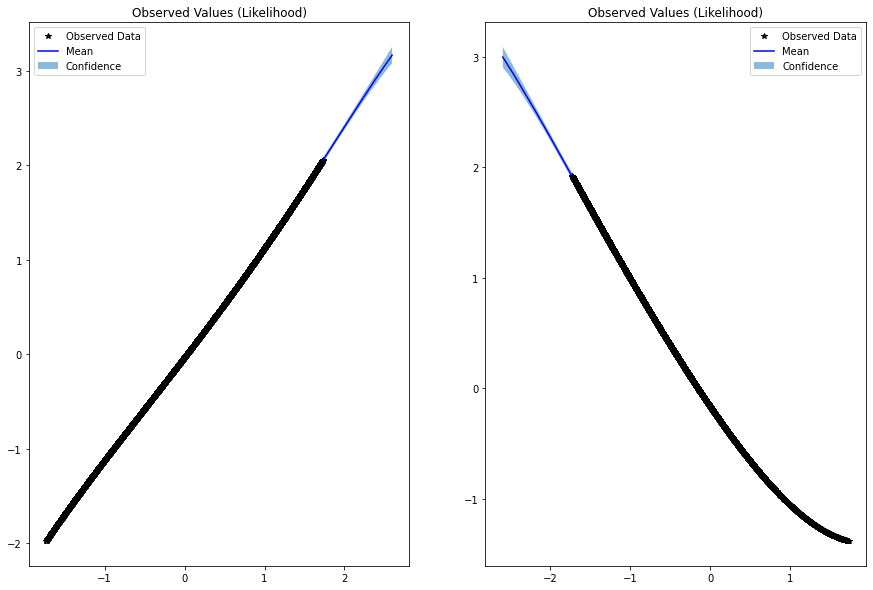

In [22]:
# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(15, 10))

# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x[:, 0].detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x[:, 0].numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x[:, 0].numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
# y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x[:, 1].detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x[:, 1].numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x[:, 1].numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
# y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

None